In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset - Sine Regressions

In [3]:
class SineWaveTask:
    def __init__(self):
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
        
    def sample_data(self, size=10):
        x = np.random.uniform(-5.0, 5.0, size)
        y = self.amplitude * np.sin(x + self.phase)
        
        return torch.tensor(x, dtype=torch.float32).unsqueeze(1), \
               torch.tensor(y, dtype=torch.float32).unsqueeze(1)

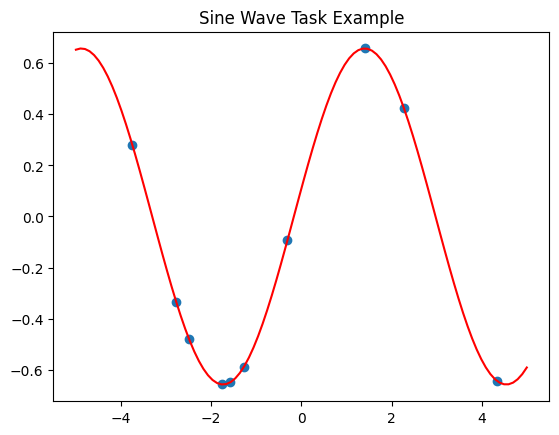

In [4]:
tset = SineWaveTask()
x, y = tset.sample_data(10)
amp, phase = tset.amplitude, tset.phase

plt.plot(np.linspace(-5, 5, 100), amp * np.sin(np.linspace(-5, 5, 100) + phase), color='red')
plt.scatter(x.numpy(), y.numpy())
plt.title("Sine Wave Task Example")
plt.show()

## Baseline MLP

In [5]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1):
        super(simpleNN, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

        self.tanh = nn.Tanh()

        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight.data)
    
    def forward(self, x, params=None):
        if params is None:
            x = self.tanh(self.linear1(x))
            x = self.tanh(self.linear2(x))
            x = self.output(x)
        else:
            x = self.tanh(F.linear(x, params['linear1.weight'], params['linear1.bias']))
            x = self.tanh(F.linear(x, params['linear2.weight'], params['linear2.bias']))
            x = F.linear(x, params['output.weight'], params['output.bias'])
        return x

In [37]:
def train_baseline(model, tasks, epochs=1000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for task in tasks:
            x_train, y_train = task.sample_data(10)
            x_val, y_val = task.sample_data(10)

            x_train, y_train = x_train.to(device), y_train.to(device)
            x_val, y_val = x_val.to(device), y_val.to(device)

            optimizer.zero_grad()
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                y_val_pred = model(x_val)
                val_loss = loss_fn(y_val_pred, y_val)
                total_loss += val_loss.item()
        
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Validation Loss: {total_loss/len(tasks)}")

In [38]:
base_model = simpleNN().to(device)
tasks = [SineWaveTask() for _ in range(10)]
train_baseline(base_model, tasks, epochs=1000, lr=0.001)

Epoch 100, Validation Loss: 5.371985638141632
Epoch 200, Validation Loss: 4.362675733864307
Epoch 300, Validation Loss: 5.007828694581986
Epoch 400, Validation Loss: 5.147017952799797
Epoch 500, Validation Loss: 4.891699552536011
Epoch 600, Validation Loss: 5.110825744271279
Epoch 700, Validation Loss: 5.614474552869797
Epoch 800, Validation Loss: 4.132461219280958
Epoch 900, Validation Loss: 4.924242874234915
Epoch 1000, Validation Loss: 5.196323303878307


In [6]:
def eval_maml(model, k_shot=10, inner_lr=0.01, adapt_steps=10, model_name="MAML"):
    task = SineWaveTask()
    task.amplitude = 3.0 
    task.phase = 0.0 
    
    x_support, y_support = task.sample_data(k_shot)

    x_support, y_support = x_support.to(device), y_support.to(device)
    
    x_all = torch.linspace(-5, 5, 100).view(-1, 1)
    y_true = task.amplitude * torch.sin(x_all + task.phase)
    
    with torch.no_grad():
        y_pre = model(x_all.to(device), params=None)
    
    # Copy model parameters
    fast_weights = OrderedDict(model.named_parameters())
    
    loss_fn = nn.MSELoss()
    
    for i in range(adapt_steps):
        pred = model(x_support, params=fast_weights)
        loss = loss_fn(pred, y_support)
        
        grads = torch.autograd.grad(loss, fast_weights.values())
        
        # SGD
        fast_weights = OrderedDict(
            (name, param - inner_lr * grad)
            for ((name, param), grad) in zip(fast_weights.items(), grads)
        )

    with torch.no_grad():
        y_post = model(x_all.to(device), params=fast_weights)

    plt.figure(figsize=(10, 6))
    
    plt.plot(x_all.numpy(), y_true.numpy(), label='Ground Truth (Sine)', color='gray', linestyle='--')
    plt.scatter(x_support.cpu().numpy(), y_support.cpu().numpy(), label=f'Support Set ({k_shot} points)', color='red', s=80, marker='x')
    plt.plot(x_all.numpy(), y_pre.cpu().numpy(), label='Pre-update (Initialization)', color='green', alpha=0.5, linestyle=':')
    plt.plot(x_all.numpy(), y_post.cpu().numpy(), label=f'Post-update ({adapt_steps} steps)', color='blue', linewidth=2)

    plt.title(f'{model_name} Adaptation Result (K={k_shot})')
    plt.legend()
    plt.ylim(-4, 4)
    plt.grid(True, alpha=0.3)
    plt.show()


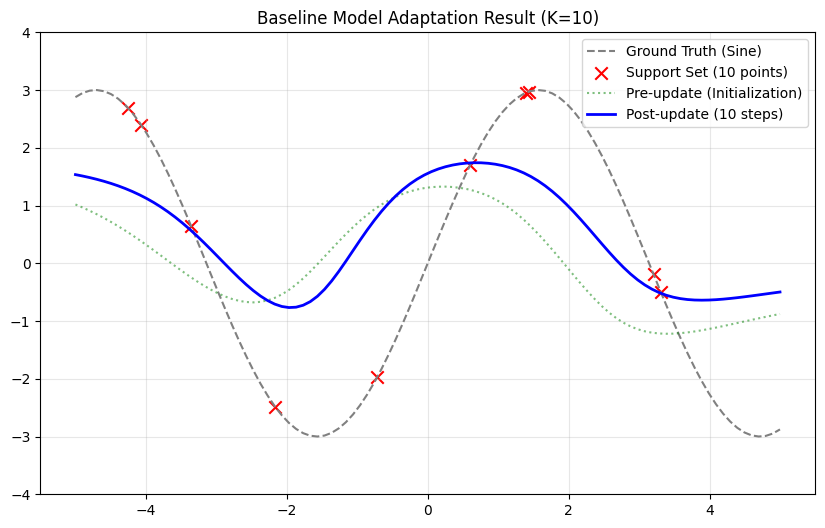

In [ ]:
eval_maml(base_model, k_shot=10, adapt_steps=10, model_name="Baseline Model")

## MAML

In [40]:
def train_maml(model, tasks, meta_epochs=1000, inner_lr=0.01, meta_lr=0.001, k_shot=10, adapt_steps=1):
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=meta_lr)
    loss_fn = nn.MSELoss()

    for epoch in range(meta_epochs):
        total_loss = 0.0
        for task in tasks:
            x_train, y_train = task.sample_data(k_shot)
            x_val, y_val = task.sample_data(k_shot)

            x_train, y_train = x_train.to(device), y_train.to(device)
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Copy model parameters
            fast_weights = OrderedDict(model.named_parameters())

            # Inner loop adaptation
            for _ in range(adapt_steps):
                pred = model(x_train, params=fast_weights)
                loss = loss_fn(pred, y_train)

                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=True)

                # SGD
                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )

            # Compute validation loss with adapted parameters
            y_val_pred = model(x_val, params=fast_weights)
            val_loss = loss_fn(y_val_pred, y_val)

            total_loss += val_loss

        # Meta-optimization step
        meta_optimizer.zero_grad()
        total_loss.backward()
        meta_optimizer.step()

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Meta Loss: {total_loss.item()/len(tasks)}")

In [41]:
model_maml = simpleNN().to(device)
train_maml(model_maml, tasks, meta_epochs=1000, inner_lr=0.01, meta_lr=0.001, k_shot=10, adapt_steps=2)

Epoch 100, Meta Loss: 5.513854217529297
Epoch 200, Meta Loss: 4.977268981933594
Epoch 300, Meta Loss: 3.8121593475341795
Epoch 400, Meta Loss: 3.146542549133301
Epoch 500, Meta Loss: 2.07619686126709
Epoch 600, Meta Loss: 0.8139509201049805
Epoch 700, Meta Loss: 0.7098583698272705
Epoch 800, Meta Loss: 0.5601180553436279
Epoch 900, Meta Loss: 0.6884314537048339
Epoch 1000, Meta Loss: 1.0061241149902345


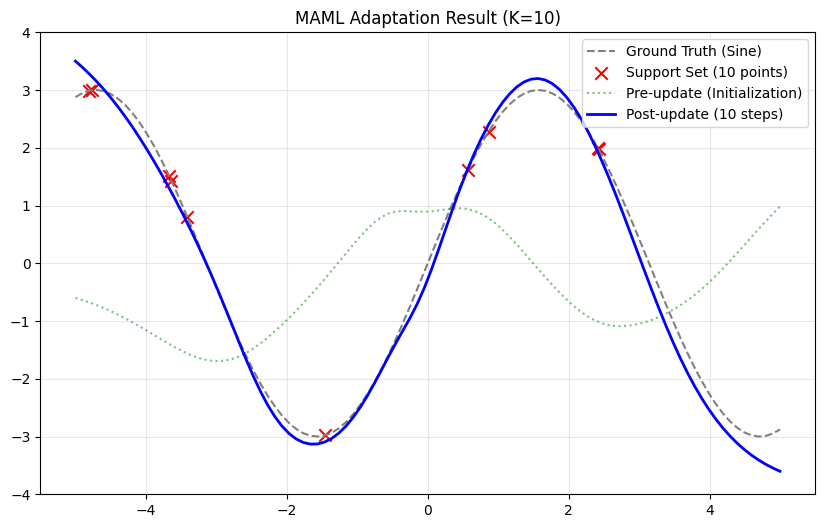

In [43]:
eval_maml(model_maml, k_shot=10, adapt_steps=10, model_name="MAML")

## Reptile

In [7]:
def train_reptile(model, tasks, meta_epochs=1000, inner_lr=0.01, meta_lr=0.001, k_shot=10, adapt_steps=1):

    loss_fn = nn.MSELoss()

    for epoch in range(meta_epochs):
        total_loss = 0.0
        meta_grad_buffer = {n: torch.zeros_like(p) for n, p in model.named_parameters()}
        for task in tasks:
            x_train, y_train = task.sample_data(k_shot)
            x_val, y_val = task.sample_data(k_shot)

            x_train, y_train = x_train.to(device), y_train.to(device)
            x_val, y_val = x_val.to(device), y_val.to(device)

            # Copy model parameters
            fast_weights = OrderedDict(model.named_parameters())

            # Inner loop adaptation
            for _ in range(adapt_steps):
                pred = model(x_train, params=fast_weights)
                loss = loss_fn(pred, y_train)
                
                grads = torch.autograd.grad(loss, fast_weights.values(), create_graph=False)

                max_norm = 1.0 
                total_norm = 0.0
                for g in grads:
                    param_norm = g.data.norm(2)
                    total_norm += param_norm.item() ** 2
                total_norm = total_norm ** 0.5

                clip_coef = max_norm / (total_norm + 1e-6)
                if clip_coef < 1:
                    grads = [g * clip_coef for g in grads]

                grads = [torch.clamp(g, -1.0, 1.0) for g in grads]

                fast_weights = OrderedDict(
                    (name, param - inner_lr * grad)
                    for ((name, param), grad) in zip(fast_weights.items(), grads)
                )

            # Validation Loss
            with torch.no_grad():
                y_val_pred = model(x_val, params=fast_weights)
                val_loss = loss_fn(y_val_pred, y_val)
                total_loss += val_loss

            for name, param in model.named_parameters():
                diff = fast_weights[name].detach() - param.detach()
                meta_grad_buffer[name] += diff
        

        # Meta-optimization step
        with torch.no_grad():
            for name, param in model.named_parameters():
                param.data += meta_lr * (meta_grad_buffer[name] / len(tasks))

        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}, Meta Loss: {total_loss.item()/len(tasks)}")

In [104]:
reptile_model = simpleNN().to(device)
tasks = [SineWaveTask() for _ in range(10)]
train_reptile(reptile_model, tasks, meta_epochs=1000, inner_lr=0.05, meta_lr=0.1, k_shot=10, adapt_steps=30)

Epoch 100, Meta Loss: 0.7937578201293946
Epoch 200, Meta Loss: 0.909760856628418
Epoch 300, Meta Loss: 0.6069175720214843
Epoch 400, Meta Loss: 0.48491196632385253
Epoch 500, Meta Loss: 0.46085643768310547
Epoch 600, Meta Loss: 0.7992431163787842
Epoch 700, Meta Loss: 0.6639456272125244
Epoch 800, Meta Loss: 0.8396699905395508
Epoch 900, Meta Loss: 1.0679813385009767
Epoch 1000, Meta Loss: 0.2757011890411377


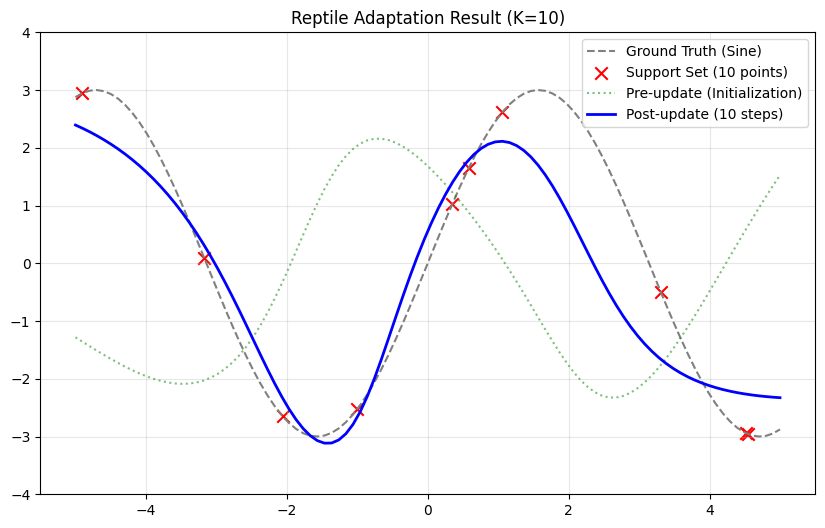

In [116]:
eval_maml(reptile_model, k_shot=10, adapt_steps=10, model_name="Reptile")